In [ ]:
# Imports and global configuration
import sys
import os
from pathlib import Path

sys.path.append(str(Path("..").resolve()))
sys.path.append(os.path.abspath("../src"))

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import tensorflow as tf

import src.pinn.pinn_forward_solver as pinn
import src.pinn.neural_networks_utils as nns
import src.data_preparation.data_utils as hf
import src.pinn.pinn_utils as phf

# System parameter (Lorenz)
A, B, C = 10.0, 0.5, 8.0 / 3.0
t_min, t_max = 0.0, 15.0

# Architectur
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Training parameter
LEARNING_RATE = 0.01
DECAY_RATE = 0.09
EPOCHS = 5000
COLLOCATION_POINTS = 1024
ALPHA_DATA = 0.5
OPTIMIZER = tf.keras.optimizers.Adam


In [ ]:
# Functions

def build_models():
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=1000,
        decay_rate=DECAY_RATE
    )
    nn_model = nns.build_standard_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
    nn_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule), loss='mse')

    nn_l2_model = nns.build_l2_regularized_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
    nn_l2_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule), loss='mse')

    pinn_model = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
    return nn_model, nn_l2_model, pinn_model

def train_and_predict(IC, mode='full'):
    # Reference solution
    t_eval, sol_rk45 = hf.ref_solution(A, B, C, t_min, t_max, IC)

    # Prepare data
    t_data, y_data = hf.generate_noisy_data(sol_rk45, t_min, t_max, noise_factor=0.3)
    if mode == 'gap':
        t_data, y_data = hf.generate_noisy_data_with_gap(sol_rk45, t_min, t_max, 4, 7, 0.5)
    elif mode == 'partial':
        y_data = hf.generate_partial_noisy_data(y_data, column='x')

    # Build model
    nn_model, nn_l2_model, pinn_model = build_models()

    # Training
    nn_model.fit(t_data, y_data, epochs=EPOCHS, batch_size=32, verbose=0)
    nn_l2_model.fit(t_data, y_data, epochs=EPOCHS, batch_size=32, verbose=0)
    pinn.train(
        pinn_model,
        t_initial=t_min,
        initial_conditions=IC,
        A=A, B=B, C=C,
        t_min=t_min, t_max=t_max,
        collocation_points=COLLOCATION_POINTS,
        alpha=ALPHA_DATA,
        learning_rate=LEARNING_RATE,
        decay_rate=DECAY_RATE,
        epochs=EPOCHS,
        optimizer_class=OPTIMIZER,
        normalize_input=False,
        data_active=True,
        t_data=t_data,
        y_data=y_data
    )

    # Prediciton
    y_nn, _ = pinn.pinn_predict(nn_model, t_eval, t_min, t_max, normalize_input=False, A=A, B=B, C=C)
    y_l2, _ = pinn.pinn_predict(nn_l2_model, t_eval, t_min, t_max, normalize_input=False, A=A, B=B, C=C)
    y_pinn, _ = pinn.pinn_predict(pinn_model, t_eval, t_min, t_max, normalize_input=False, A=A, B=B, C=C)

    return t_eval, sol_rk45, t_data.numpy(), y_data.numpy(), [y_nn, y_l2, y_pinn]

def plot_results(t_eval, sol, t_data_np, y_data_np, predictions, IC, mode='full'):
    labels = ['x(t)', 'y(t)', 'z(t)']
    models = ['Standard NN', 'L2-regularized NN', 'PINN']
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    for i in range(3):
        axs[i].plot(t_eval, sol.y[i], 'k--', linewidth=2, label="RK45 (Reference)")
        for j, y in enumerate(predictions):
            axs[i].plot(t_eval.flatten(), y[:, i], label=models[j])
        
        if mode != 'partial' or (mode == 'partial' and i == 0):
            axs[i].scatter(t_data_np, y_data_np[:, i], color='black', s=15, alpha=0.5, label='Noisy data')
        
        axs[i].set_ylabel(labels[i])
        axs[i].legend(loc='upper right')
        axs[i].grid(True)

    axs[-1].set_xlabel('t')
    
    # Title
    r_value = B.numpy() if isinstance(B, tf.Variable) else B
    plt.suptitle(f"PINN comparison - mode={mode}, IC={tuple(IC)}, r={r_value:.3f}")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def run_single_experiment(IC, mode='full'):
    t_eval, sol, t_data_np, y_data_np, predictions = train_and_predict(IC, mode)
    plot_results(t_eval, sol, t_data_np, y_data_np, predictions, IC, mode)

def run_all_experiments(ic_list):
    modes = ['full', 'gap', 'partial']
    for IC in ic_list:
        for mode in modes:
            print(f"Running IC={IC}, mode={mode}")
            run_single_experiment(IC, mode)


Running IC=[1.0, 1.0, 1.0], mode=full
Training started...
Epoch     0 | Loss: 1.9999e+00 | Data/IC-Loss: 1.2113e-01 | Physics-Loss: 3.8786e+00
Epoch  1000 | Loss: 4.0638e-02 | Data/IC-Loss: 8.0393e-02 | Physics-Loss: 8.8340e-04
Epoch  2000 | Loss: 4.0217e-02 | Data/IC-Loss: 7.9422e-02 | Physics-Loss: 1.0121e-03
Epoch  3000 | Loss: 4.0093e-02 | Data/IC-Loss: 7.9343e-02 | Physics-Loss: 8.4344e-04
Epoch  4000 | Loss: 4.0172e-02 | Data/IC-Loss: 7.9326e-02 | Physics-Loss: 1.0192e-03
Epoch  4999 | Loss: 4.0126e-02 | Data/IC-Loss: 7.9324e-02 | Physics-Loss: 9.2743e-04
Training finished!


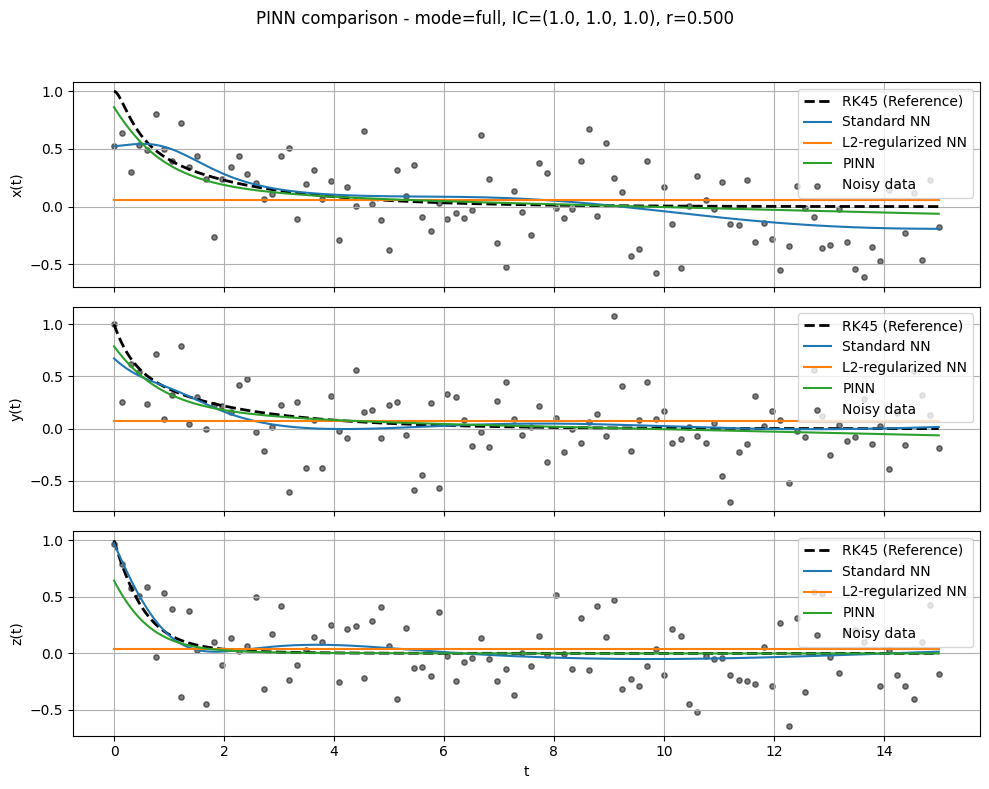

Running IC=[1.0, 1.0, 1.0], mode=gap
Training started...
Epoch     0 | Loss: 5.7783e-01 | Data/IC-Loss: 3.0778e-01 | Physics-Loss: 8.4788e-01
Epoch  1000 | Loss: 1.3143e-01 | Data/IC-Loss: 2.6070e-01 | Physics-Loss: 2.1651e-03
Epoch  2000 | Loss: 1.3101e-01 | Data/IC-Loss: 2.6024e-01 | Physics-Loss: 1.7796e-03
Epoch  3000 | Loss: 1.3098e-01 | Data/IC-Loss: 2.6021e-01 | Physics-Loss: 1.7412e-03
Epoch  4000 | Loss: 1.3100e-01 | Data/IC-Loss: 2.6021e-01 | Physics-Loss: 1.7802e-03
Epoch  4999 | Loss: 1.3106e-01 | Data/IC-Loss: 2.6021e-01 | Physics-Loss: 1.9020e-03
Training finished!


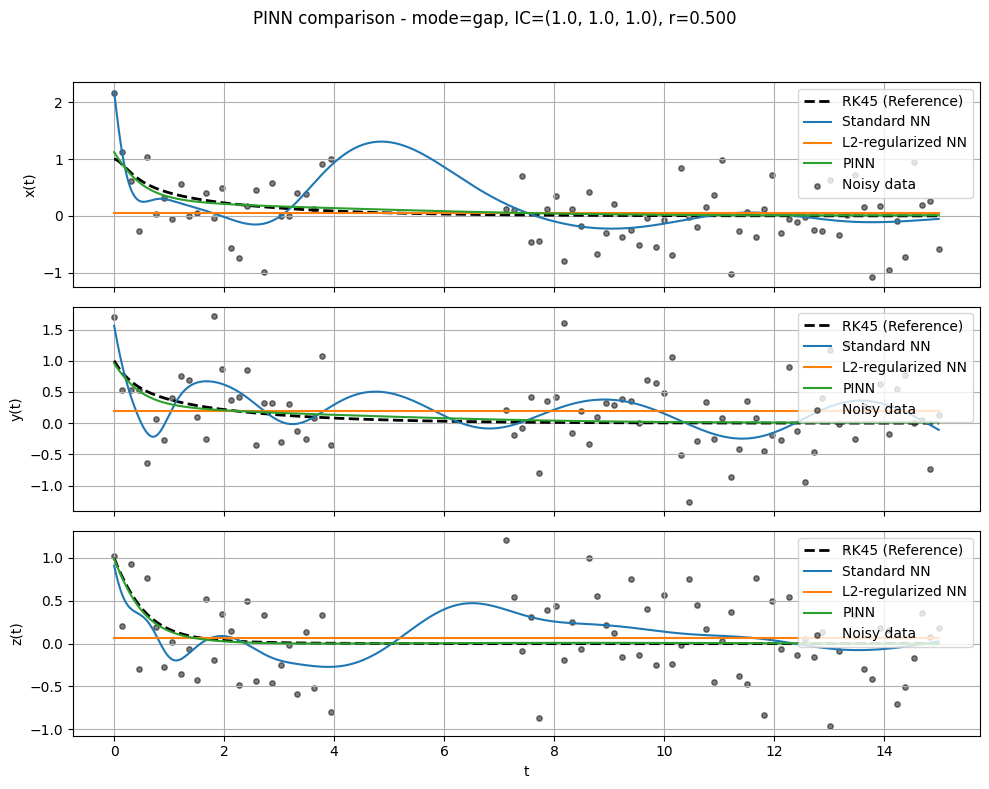

Running IC=[1.0, 1.0, 1.0], mode=partial
Test
Training started...
Epoch     0 | Loss: 3.5087e-01 | Data/IC-Loss: 1.7011e-01 | Physics-Loss: 5.3162e-01
Epoch  1000 | Loss: 5.5186e-02 | Data/IC-Loss: 1.0828e-01 | Physics-Loss: 2.0888e-03
Epoch  2000 | Loss: 5.5005e-02 | Data/IC-Loss: 1.0810e-01 | Physics-Loss: 1.9151e-03
Epoch  3000 | Loss: 5.4729e-02 | Data/IC-Loss: 1.0804e-01 | Physics-Loss: 1.4150e-03
Epoch  4000 | Loss: 5.4637e-02 | Data/IC-Loss: 1.0805e-01 | Physics-Loss: 1.2246e-03
Epoch  4999 | Loss: 5.4710e-02 | Data/IC-Loss: 1.0805e-01 | Physics-Loss: 1.3703e-03
Training finished!


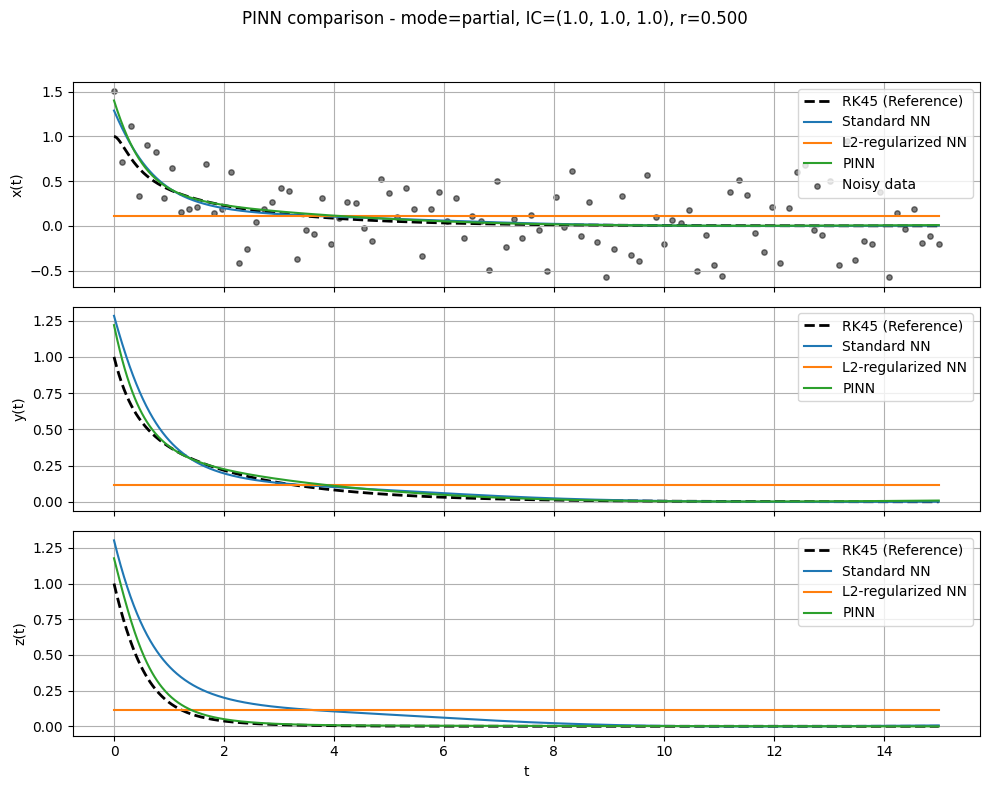

Running IC=[10, 5, 20], mode=full
Training started...
Epoch     0 | Loss: 2.0675e+00 | Data/IC-Loss: 3.1448e+00 | Physics-Loss: 9.9019e-01
Epoch  1000 | Loss: 3.1204e-01 | Data/IC-Loss: 6.1647e-01 | Physics-Loss: 7.6162e-03
Epoch  2000 | Loss: 3.1205e-01 | Data/IC-Loss: 6.1393e-01 | Physics-Loss: 1.0176e-02
Epoch  3000 | Loss: 3.1059e-01 | Data/IC-Loss: 6.1338e-01 | Physics-Loss: 7.8127e-03
Epoch  4000 | Loss: 3.1082e-01 | Data/IC-Loss: 6.1326e-01 | Physics-Loss: 8.3809e-03
Epoch  4999 | Loss: 3.0866e-01 | Data/IC-Loss: 6.1327e-01 | Physics-Loss: 4.0544e-03
Training finished!


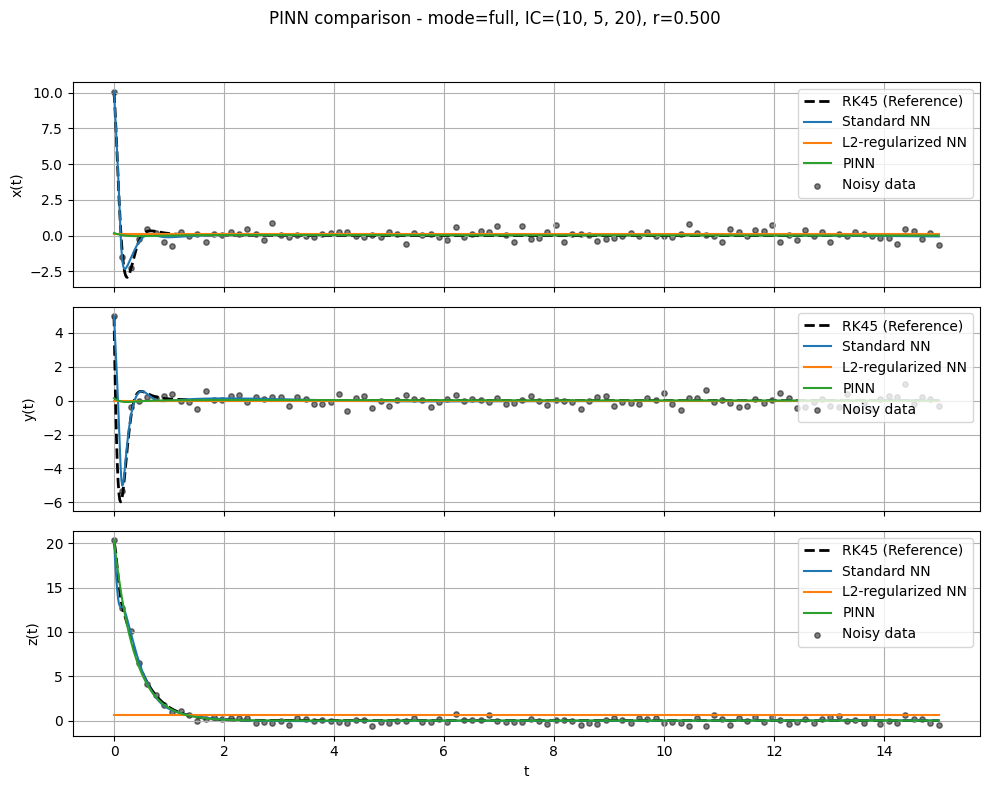

Running IC=[10, 5, 20], mode=gap
Training started...
Epoch     0 | Loss: 3.1591e+00 | Data/IC-Loss: 4.0676e+00 | Physics-Loss: 2.2507e+00
Epoch  1000 | Loss: 4.6435e-01 | Data/IC-Loss: 9.1810e-01 | Physics-Loss: 1.0604e-02
Epoch  2000 | Loss: 4.6193e-01 | Data/IC-Loss: 9.1355e-01 | Physics-Loss: 1.0301e-02
Epoch  3000 | Loss: 4.6329e-01 | Data/IC-Loss: 9.1355e-01 | Physics-Loss: 1.3032e-02
Epoch  4000 | Loss: 4.6155e-01 | Data/IC-Loss: 9.1346e-01 | Physics-Loss: 9.6458e-03
Epoch  4999 | Loss: 4.6462e-01 | Data/IC-Loss: 9.1340e-01 | Physics-Loss: 1.5836e-02
Training finished!


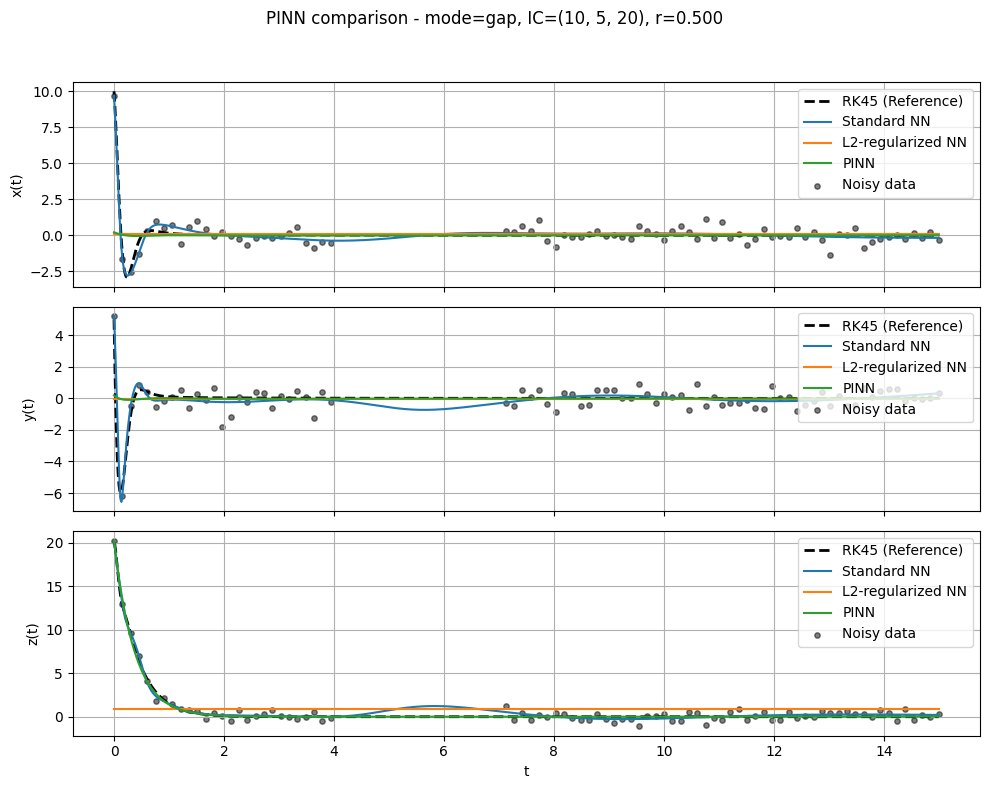

Running IC=[10, 5, 20], mode=partial
Test
Training started...
Epoch     0 | Loss: 3.2852e+00 | Data/IC-Loss: 1.1902e+00 | Physics-Loss: 5.3803e+00
Epoch  1000 | Loss: 3.3229e-01 | Data/IC-Loss: 6.5300e-01 | Physics-Loss: 1.1573e-02
Epoch  2000 | Loss: 3.1052e-01 | Data/IC-Loss: 6.0959e-01 | Physics-Loss: 1.1442e-02
Epoch  3000 | Loss: 3.1054e-01 | Data/IC-Loss: 6.0725e-01 | Physics-Loss: 1.3837e-02
Epoch  4000 | Loss: 3.1004e-01 | Data/IC-Loss: 6.0718e-01 | Physics-Loss: 1.2903e-02
Epoch  4999 | Loss: 3.0914e-01 | Data/IC-Loss: 6.0707e-01 | Physics-Loss: 1.1208e-02
Training finished!


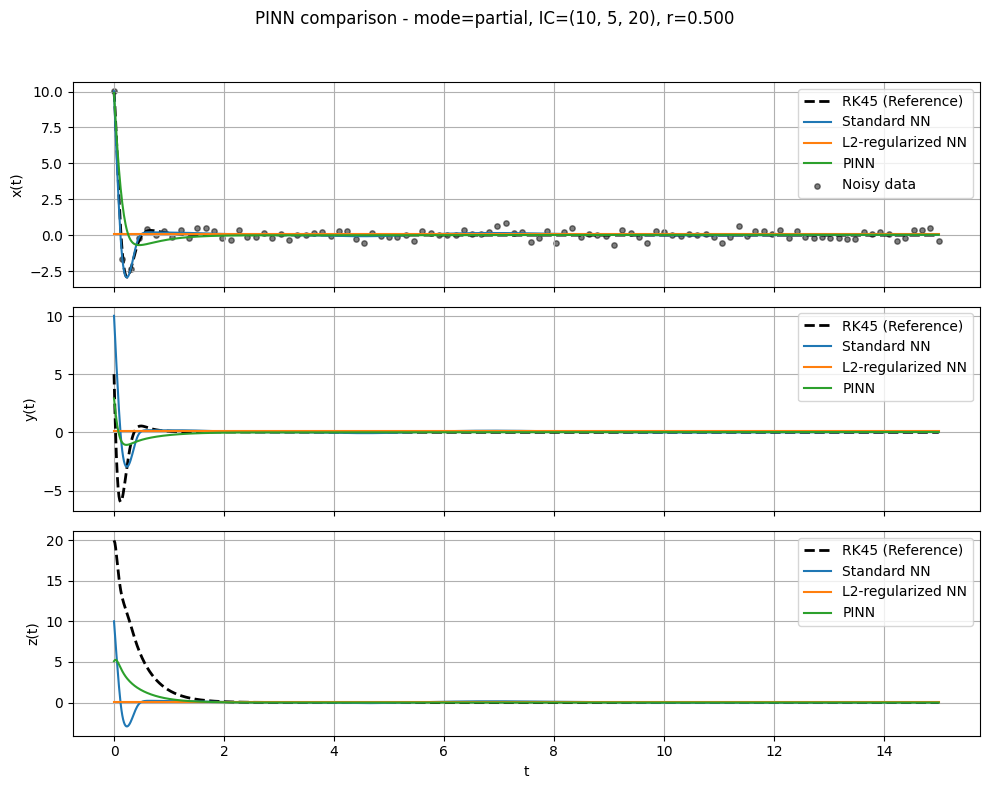

Running IC=[0, 1, 0], mode=full
Training started...
Epoch     0 | Loss: 1.2234e+01 | Data/IC-Loss: 2.1100e-01 | Physics-Loss: 2.4257e+01
Epoch  1000 | Loss: 5.5464e-02 | Data/IC-Loss: 1.0876e-01 | Physics-Loss: 2.1701e-03
Epoch  2000 | Loss: 5.2510e-02 | Data/IC-Loss: 1.0200e-01 | Physics-Loss: 3.0213e-03
Epoch  3000 | Loss: 5.1950e-02 | Data/IC-Loss: 1.0103e-01 | Physics-Loss: 2.8670e-03
Epoch  4000 | Loss: 5.1847e-02 | Data/IC-Loss: 1.0091e-01 | Physics-Loss: 2.7874e-03
Epoch  4999 | Loss: 5.1771e-02 | Data/IC-Loss: 1.0089e-01 | Physics-Loss: 2.6512e-03
Training finished!


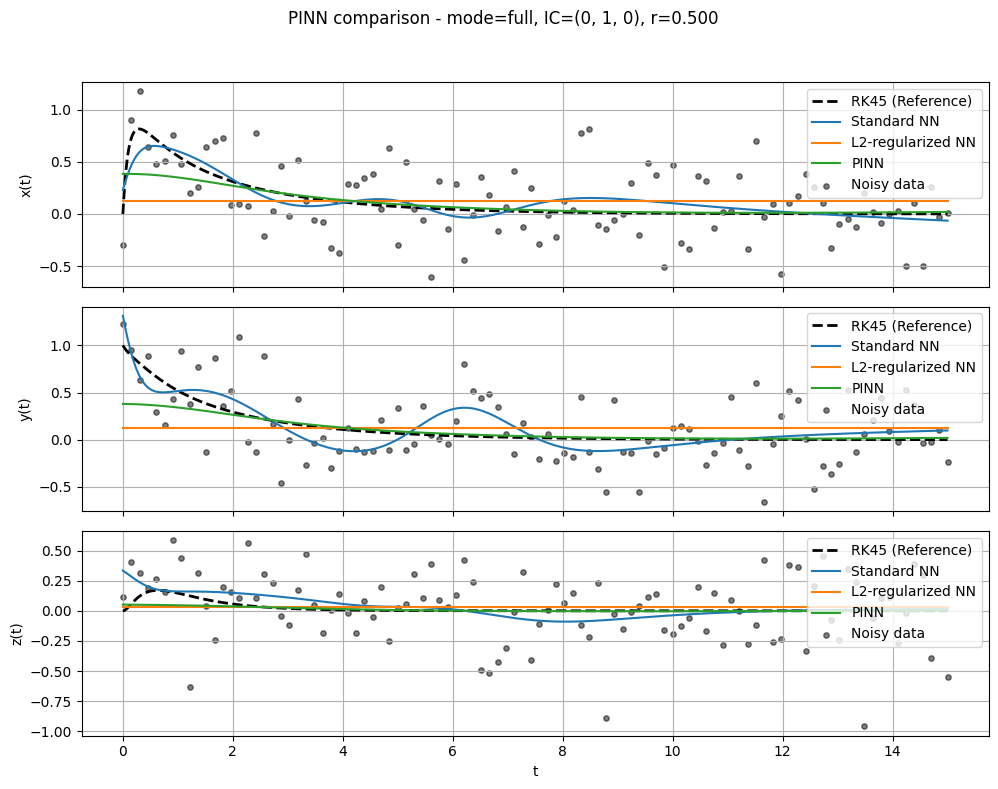

Running IC=[0, 1, 0], mode=gap
Training started...
Epoch     0 | Loss: 5.0340e-01 | Data/IC-Loss: 3.2731e-01 | Physics-Loss: 6.7950e-01
Epoch  1000 | Loss: 1.4543e-01 | Data/IC-Loss: 2.8801e-01 | Physics-Loss: 2.8421e-03
Epoch  2000 | Loss: 1.4527e-01 | Data/IC-Loss: 2.8723e-01 | Physics-Loss: 3.3141e-03
Epoch  3000 | Loss: 1.4505e-01 | Data/IC-Loss: 2.8713e-01 | Physics-Loss: 2.9619e-03
Epoch  4000 | Loss: 1.4511e-01 | Data/IC-Loss: 2.8712e-01 | Physics-Loss: 3.1053e-03
Epoch  4999 | Loss: 1.4511e-01 | Data/IC-Loss: 2.8712e-01 | Physics-Loss: 3.0882e-03
Training finished!


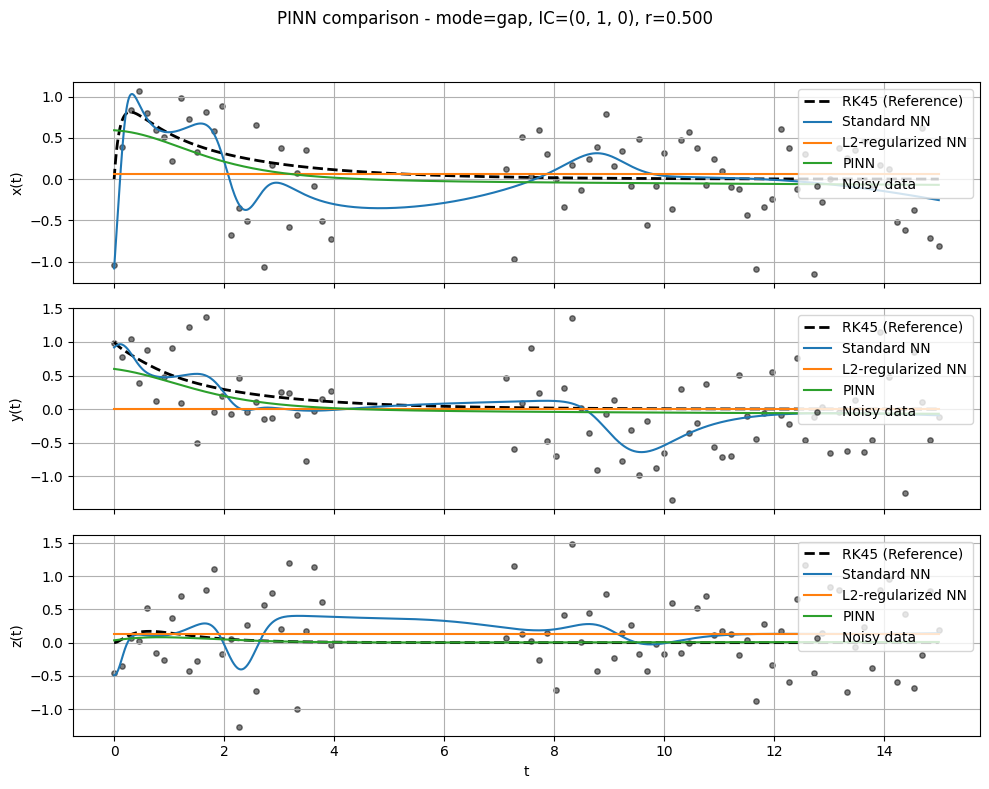

Running IC=[0, 1, 0], mode=partial
Test
Training started...
Epoch     0 | Loss: 2.8187e-01 | Data/IC-Loss: 1.2431e-01 | Physics-Loss: 4.3942e-01
Epoch  1000 | Loss: 4.3337e-02 | Data/IC-Loss: 8.5503e-02 | Physics-Loss: 1.1716e-03
Epoch  2000 | Loss: 4.3059e-02 | Data/IC-Loss: 8.5252e-02 | Physics-Loss: 8.6639e-04
Epoch  3000 | Loss: 4.3081e-02 | Data/IC-Loss: 8.5227e-02 | Physics-Loss: 9.3551e-04
Epoch  4000 | Loss: 4.3063e-02 | Data/IC-Loss: 8.5220e-02 | Physics-Loss: 9.0601e-04
Epoch  4999 | Loss: 4.3153e-02 | Data/IC-Loss: 8.5219e-02 | Physics-Loss: 1.0866e-03
Training finished!


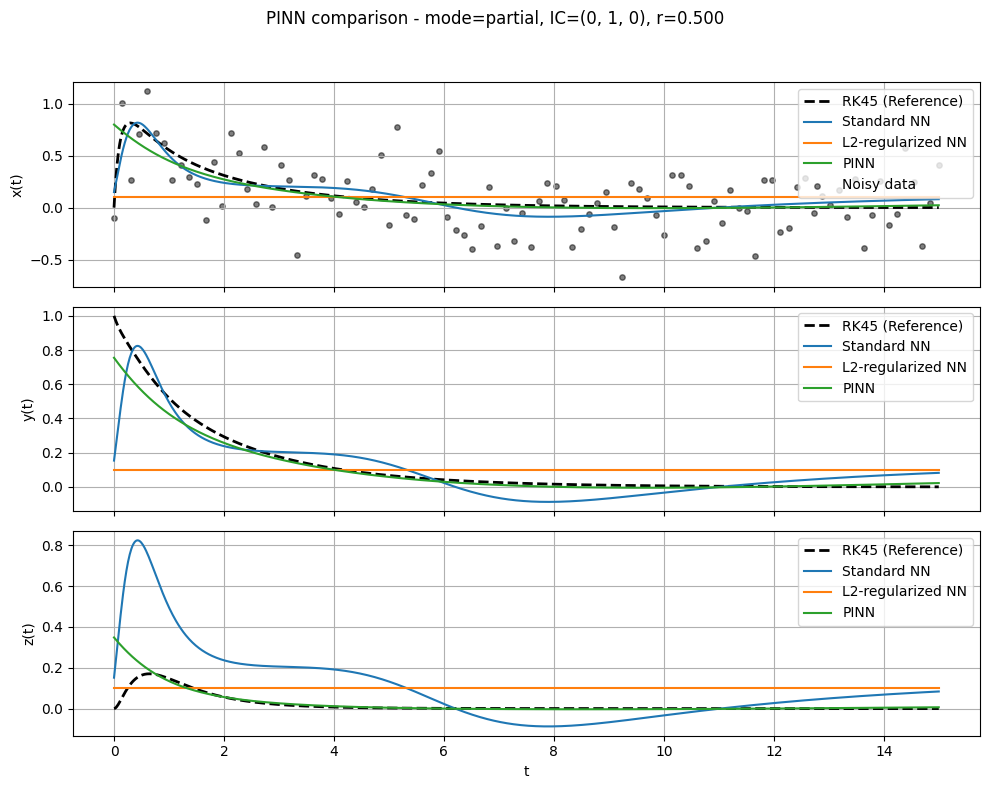

Running IC=[0, 0.0001, 0], mode=full
Training started...
Epoch     0 | Loss: 1.3393e+00 | Data/IC-Loss: 1.0248e-01 | Physics-Loss: 2.5761e+00
Epoch  1000 | Loss: 3.8430e-02 | Data/IC-Loss: 7.6606e-02 | Physics-Loss: 2.5434e-04
Epoch  2000 | Loss: 3.8393e-02 | Data/IC-Loss: 7.6461e-02 | Physics-Loss: 3.2564e-04
Epoch  3000 | Loss: 3.8393e-02 | Data/IC-Loss: 7.6446e-02 | Physics-Loss: 3.4057e-04
Epoch  4000 | Loss: 3.8390e-02 | Data/IC-Loss: 7.6444e-02 | Physics-Loss: 3.3695e-04
Epoch  4999 | Loss: 3.8392e-02 | Data/IC-Loss: 7.6444e-02 | Physics-Loss: 3.4117e-04
Training finished!


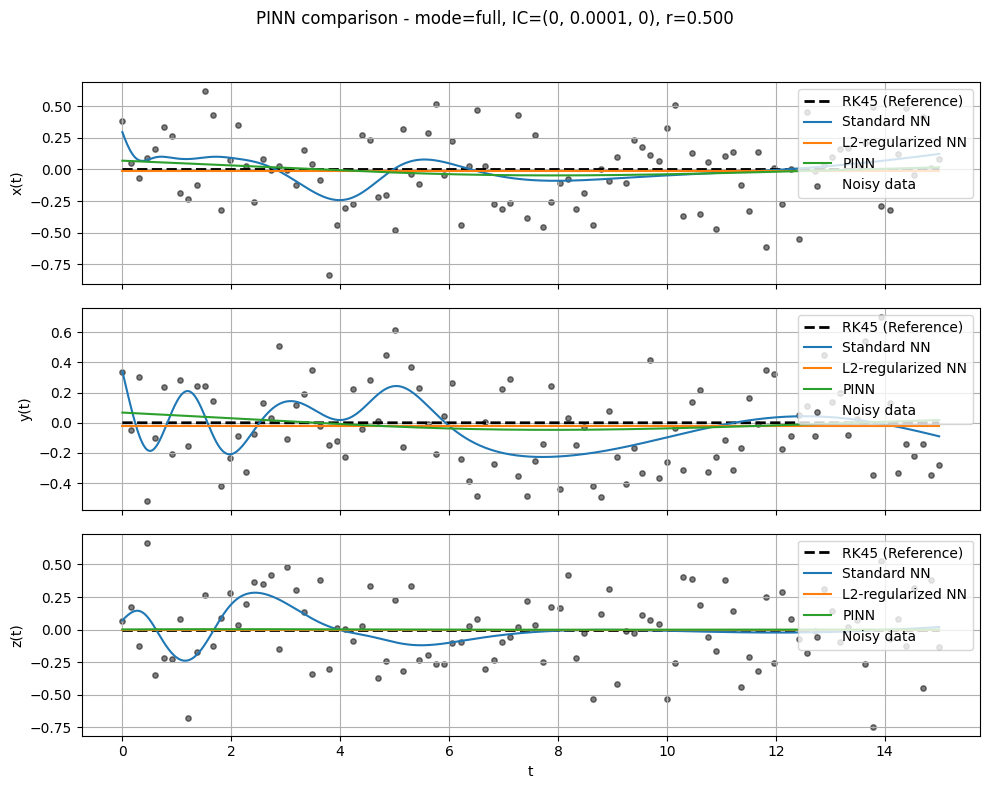

Running IC=[0, 0.0001, 0], mode=gap
Training started...
Epoch     0 | Loss: 1.5376e-01 | Data/IC-Loss: 2.7750e-01 | Physics-Loss: 3.0022e-02
Epoch  1000 | Loss: 1.3169e-01 | Data/IC-Loss: 2.6161e-01 | Physics-Loss: 1.7702e-03
Epoch  2000 | Loss: 1.3158e-01 | Data/IC-Loss: 2.6099e-01 | Physics-Loss: 2.1668e-03
Epoch  3000 | Loss: 1.3150e-01 | Data/IC-Loss: 2.6084e-01 | Physics-Loss: 2.1581e-03
Epoch  4000 | Loss: 1.3149e-01 | Data/IC-Loss: 2.6082e-01 | Physics-Loss: 2.1571e-03
Epoch  4999 | Loss: 1.3144e-01 | Data/IC-Loss: 2.6082e-01 | Physics-Loss: 2.0484e-03
Training finished!


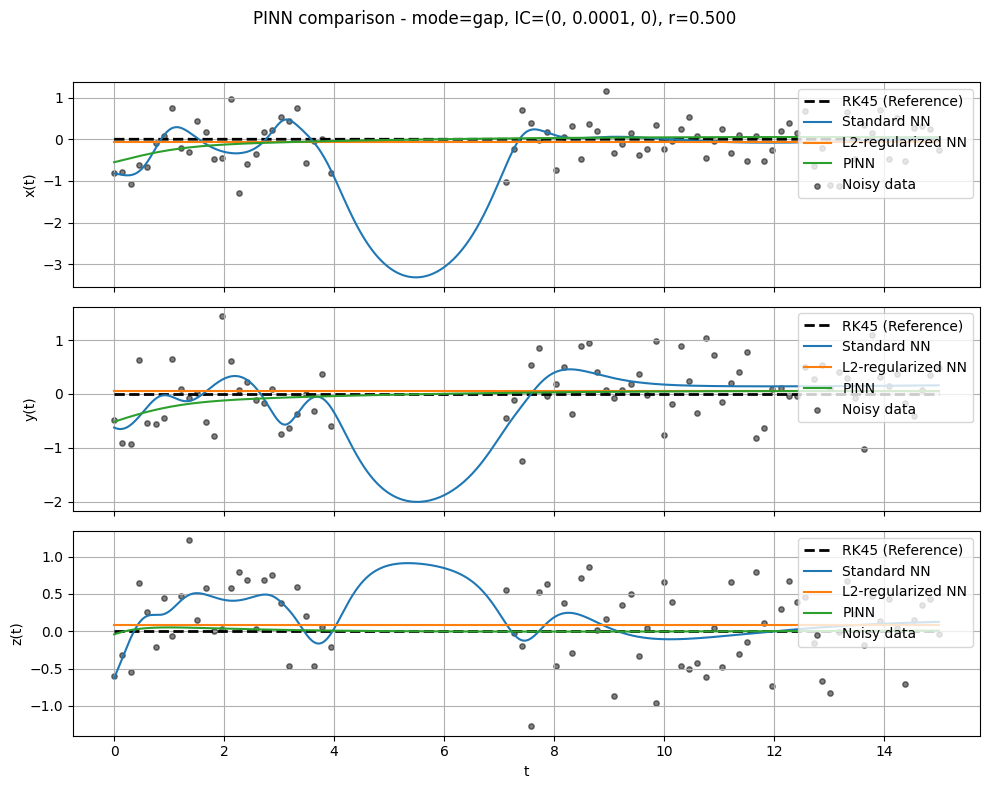

Running IC=[0, 0.0001, 0], mode=partial
Test
Training started...
Epoch     0 | Loss: 1.2305e+00 | Data/IC-Loss: 9.8657e-02 | Physics-Loss: 2.3624e+00
Epoch  1000 | Loss: 3.8047e-02 | Data/IC-Loss: 7.5885e-02 | Physics-Loss: 2.0889e-04
Epoch  2000 | Loss: 3.8036e-02 | Data/IC-Loss: 7.5845e-02 | Physics-Loss: 2.2582e-04
Epoch  3000 | Loss: 3.8035e-02 | Data/IC-Loss: 7.5840e-02 | Physics-Loss: 2.2943e-04
Epoch  4000 | Loss: 3.8031e-02 | Data/IC-Loss: 7.5840e-02 | Physics-Loss: 2.2188e-04
Epoch  4999 | Loss: 3.8032e-02 | Data/IC-Loss: 7.5840e-02 | Physics-Loss: 2.2362e-04
Training finished!


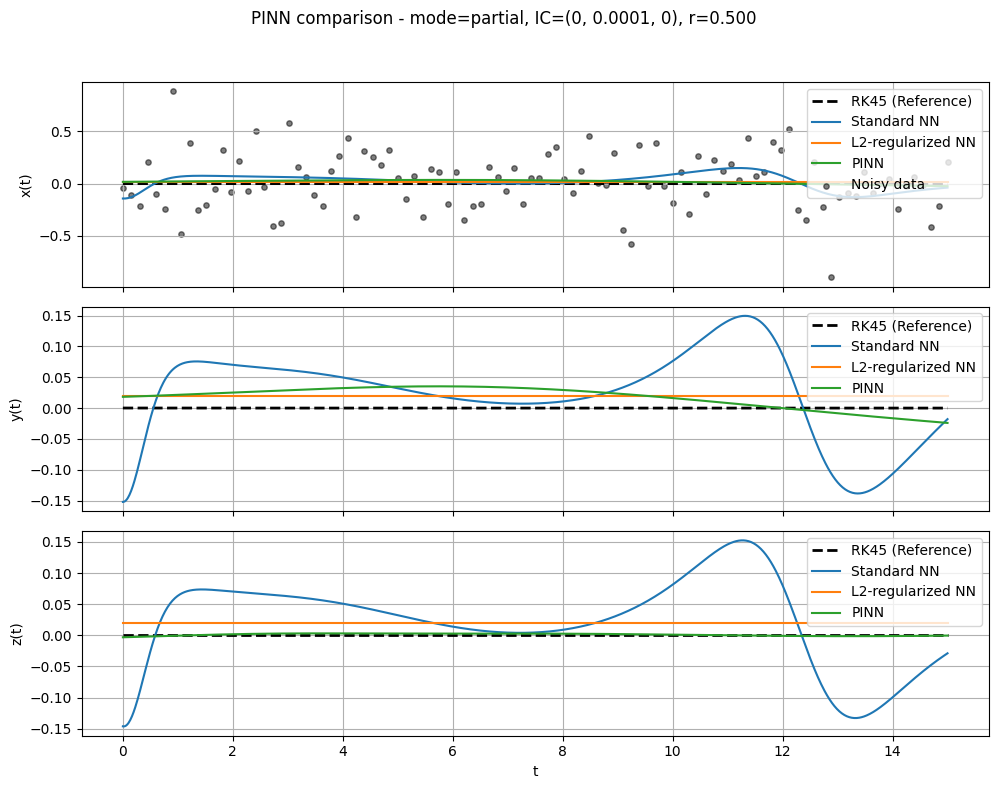

Running IC=[0.5, 0.5, 0.1], mode=full
Training started...
Epoch     0 | Loss: 1.5961e-01 | Data/IC-Loss: 1.0925e-01 | Physics-Loss: 2.0997e-01
Epoch  1000 | Loss: 4.5759e-02 | Data/IC-Loss: 9.1059e-02 | Physics-Loss: 4.6040e-04
Epoch  2000 | Loss: 4.5550e-02 | Data/IC-Loss: 9.0759e-02 | Physics-Loss: 3.4047e-04
Epoch  3000 | Loss: 4.5533e-02 | Data/IC-Loss: 9.0725e-02 | Physics-Loss: 3.4078e-04
Epoch  4000 | Loss: 4.5512e-02 | Data/IC-Loss: 9.0720e-02 | Physics-Loss: 3.0337e-04
Epoch  4999 | Loss: 4.5538e-02 | Data/IC-Loss: 9.0720e-02 | Physics-Loss: 3.5618e-04
Training finished!


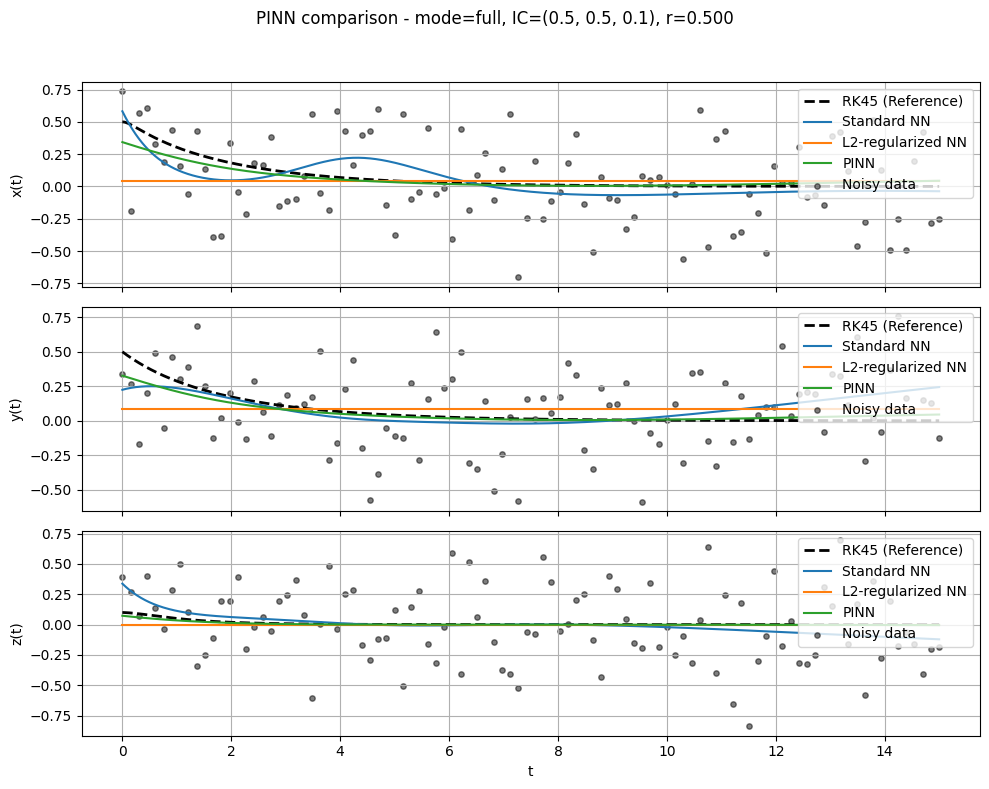

Running IC=[0.5, 0.5, 0.1], mode=gap
Training started...
Epoch     0 | Loss: 9.4042e-01 | Data/IC-Loss: 2.8826e-01 | Physics-Loss: 1.5926e+00
Epoch  1000 | Loss: 1.2739e-01 | Data/IC-Loss: 2.5144e-01 | Physics-Loss: 3.3432e-03
Epoch  2000 | Loss: 1.2624e-01 | Data/IC-Loss: 2.5058e-01 | Physics-Loss: 1.8951e-03
Epoch  3000 | Loss: 1.2637e-01 | Data/IC-Loss: 2.5060e-01 | Physics-Loss: 2.1386e-03
Epoch  4000 | Loss: 1.2628e-01 | Data/IC-Loss: 2.5060e-01 | Physics-Loss: 1.9676e-03
Epoch  4999 | Loss: 1.2649e-01 | Data/IC-Loss: 2.5060e-01 | Physics-Loss: 2.3797e-03
Training finished!


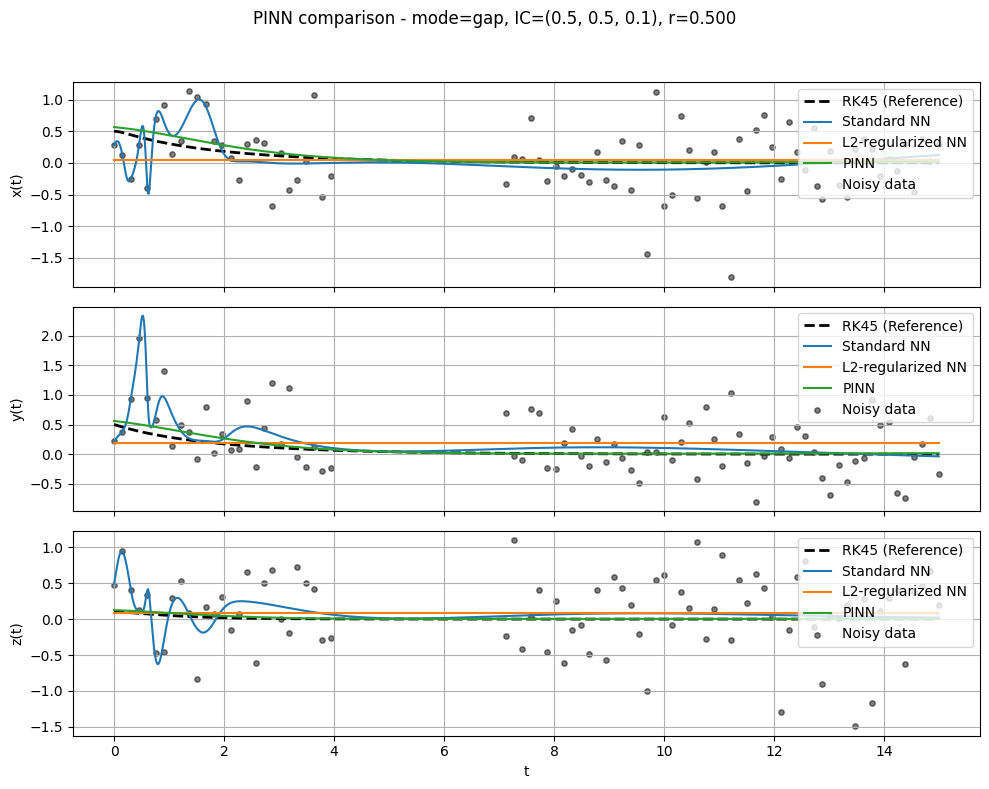

Running IC=[0.5, 0.5, 0.1], mode=partial
Test
Training started...
Epoch     0 | Loss: 9.0429e-01 | Data/IC-Loss: 1.0315e-01 | Physics-Loss: 1.7054e+00
Epoch  1000 | Loss: 4.3002e-02 | Data/IC-Loss: 8.5310e-02 | Physics-Loss: 6.9504e-04
Epoch  2000 | Loss: 4.1676e-02 | Data/IC-Loss: 8.2659e-02 | Physics-Loss: 6.9266e-04
Epoch  3000 | Loss: 4.1538e-02 | Data/IC-Loss: 8.2462e-02 | Physics-Loss: 6.1393e-04
Epoch  4000 | Loss: 4.1602e-02 | Data/IC-Loss: 8.2442e-02 | Physics-Loss: 7.6249e-04
Epoch  4999 | Loss: 4.1570e-02 | Data/IC-Loss: 8.2440e-02 | Physics-Loss: 6.9914e-04
Training finished!


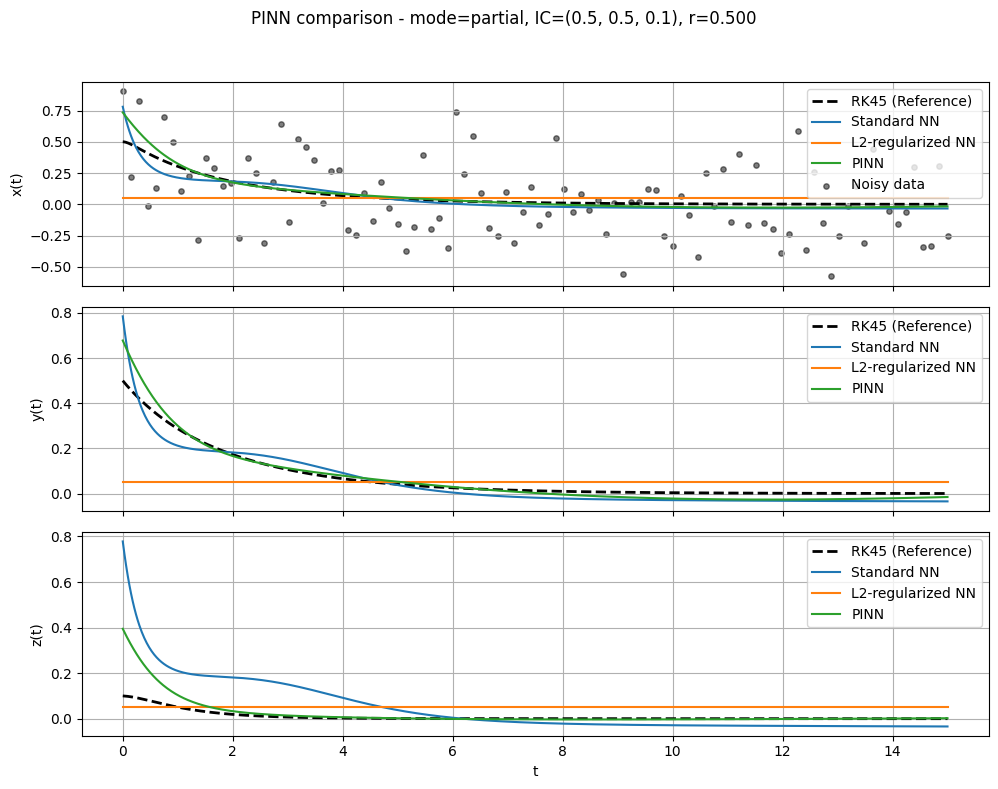

In [ ]:
# Run
initial_conditions_list = [
    [1.0, 1.0, 1.0],
    [10, -5, 20],
    [0,1,0],
    [0, 0.0001, 0],
    [0.5, 0.5, 0.1]
]

run_all_experiments(initial_conditions_list)
